### Loading libraries

In [1]:
import os,sys
import numpy as np
os.environ["R_HOME"]="/".join(
    np.array(sys.executable.split("/"))[:-2]
)+"/lib/R/"

In [2]:
import scFates as scf
import scanpy as sc
import pandas as pd
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

### Loading processed TGFb data

In [3]:
%%R -o adata
load("tgfb.RData")
adata=sce

/home/lfaure/miniconda3/envs/scFates_bench/lib/python3.8/site-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)
/home/lfaure/miniconda3/envs/scFates_bench/lib/python3.8/site-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


In [4]:
import scipy.sparse as sp
adata.X=sp.csr_matrix(adata.X)
sc.pp.normalize_total(adata,target_sum=1e6)
sc.pp.log1p(adata,base=10)

adata

AnnData object with n_obs × n_vars = 9268 × 10549
    obs: 'cell', 'total_umis', 'sample', 'TSNE.1', 'TSNE.2', 'Size_Factor', 'treatment_id', 'spatial_id', 'slingPseudotime_1'
    uns: 'log1p'
    obsm: 'X_umap'

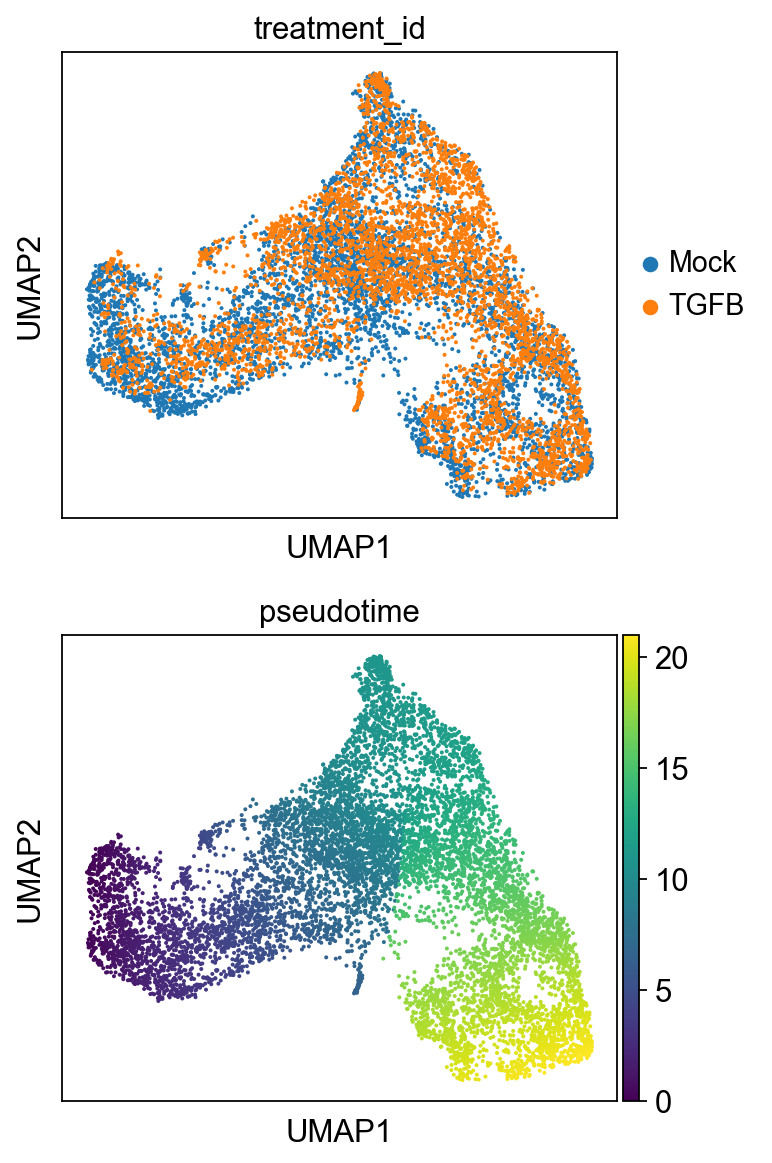

In [5]:
import matplotlib.pyplot as plt
sc.set_figure_params()
scf.set_figure_pubready()
(ax1,ax2)=sc.pl.umap(adata,color=["treatment_id","slingPseudotime_1"],show=False,ncols=1)
ax2.set_title("pseudotime")
plt.savefig("figures/covariate_1.pdf",dpi=300)

### Covariate pseudotime association testing

We are using Slingshot pseudotime for analysis

In [6]:
adata.obs["t"]=adata.obs["slingPseudotime_1"]
adata.obs["seg"]="1"

In [7]:
scf.tl.test_association_covariate(adata,"treatment_id",n_jobs=40)

test association covariates
test features for association with the trajectory
    single mapping : 100%|██████████| 10549/10549 [02:26<00:00, 72.14it/s]
    found 1146 significant features (0:02:26)


/home/lfaure/scFates/scFates/tools/test_association.py:413: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var[c] = stat_assoc[c]


test features for association with the trajectory
    single mapping : 100%|██████████| 10549/10549 [02:01<00:00, 87.03it/s]
    found 530 significant features (0:02:01)


/home/lfaure/scFates/scFates/tools/test_association.py:413: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var[c] = stat_assoc[c]


    finished --> added 
    .var['Mock_pval'] values from statistical test.
    .var['Mock_fdr'] corrected values from multiple testing.
    .var['Mock_A'] amplitue of change of tested feature.
    .var['Mock_signi'] feature is significantly changing along pseudotime.
    .var['TGFB_pval'] values from statistical test.
    .var['TGFB_fdr'] corrected values from multiple testing.
    .var['TGFB_A'] amplitue of change of tested feature.
    .var['TGFB_signi'] feature is significantly changing along pseudotime.
    .var['signi'], intersection of both significant list of genes.


In [8]:
adata=adata[:,adata.var.signi]

### Covariate amplitude testing

In [9]:
scf.tl.test_covariate(adata,"treatment_id",n_jobs=40,)

testing covariates (amplitude)
    single mapping : 100%|██████████| 1297/1297 [00:30<00:00, 43.19it/s]
    found 947 significant features (0:00:33)
    finished (0:00:00) --> added 
    .var['cov_pval'], pvalues extracted from tests.
    .var['cov_FDR'], FDR extracted from the pvalues.
    .var['cov_signi'], is the feature significant.
    .var['Mock->TGFB_lfc'], logfoldchange in expression between covariate Mock and TGFB.


/home/lfaure/scFates/scFates/tools/covariate.py:128: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var[f"{res}_pval"] = np.nan


### Covariate trend testing

In [10]:
scf.tl.test_covariate(adata,"treatment_id",n_jobs=40,trend_test=True)

testing covariates (trend)
    single mapping : 100%|██████████| 1297/1297 [00:45<00:00, 28.74it/s]
    found 966 significant features (0:00:48)
    finished (0:00:00) --> added 
    .var['covtrend_pval'], pvalues extracted from tests.
    .var['covtrend_FDR'], FDR extracted from the pvalues.
    .var['covtrend_signi'], is the feature significant.
    .var['Mock->TGFB_lfc'], logfoldchange in expression between covariate Mock and TGFB.


### Getting results

In [11]:
adata.var.sort_values("Mock->TGFB_lfc")

,Mock_p_val,Mock_A,Mock_fdr,Mock_signi,TGFB_p_val,TGFB_A,TGFB_fdr,TGFB_signi,signi,cov_pval,cov_fdr,cov_signi,Mock->TGFB_lfc,covtrend_pval,covtrend_fdr,covtrend_signi
FN1,1.446134e-25,0.210973,1.525527e-21,False,1.787960e-258,1.669675,1.886119e-254,True,True,0.000000e+00,0.000000e+00,1,-11.481741,1.908334e-204,2.475109e-201,1
TGM2,2.152962e-01,0.013332,1.000000e+00,False,1.613130e-102,1.627598,1.701691e-98,True,True,0.000000e+00,0.000000e+00,1,-10.940114,1.253704e-137,1.626054e-134,1
FBLN5,1.958442e-08,0.057309,2.065961e-04,False,1.179482e-204,1.831296,1.244235e-200,True,True,0.000000e+00,0.000000e+00,1,-9.426566,4.014442e-252,5.206732e-249,1
ALOX5AP,2.488480e-06,0.040067,2.625097e-02,False,2.632204e-98,1.542224,2.776712e-94,True,True,0.000000e+00,0.000000e+00,1,-9.253103,1.889343e-129,2.450478e-126,1
SCG5,6.650826e-08,0.049097,7.015957e-04,False,1.304457e-116,1.377601,1.376072e-112,True,True,0.000000e+00,0.000000e+00,1,-8.896863,8.129357e-153,1.054378e-149,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PI3,0.000000e+00,2.574340,0.000000e+00,True,3.742335e-32,0.738296,3.947790e-28,False,True,0.000000e+00,0.000000e+00,1,7.228684,1.100261e-284,1.427038e-281,1
SPRR1A,0.000000e+00,3.320073,0.000000e+00,True,2.721662e-166,0.889561,2.871082e-162,False,True,0.000000e+00,0.000000e+00,1,7.379507,4.812290e-261,6.241540e-258,1
CDSN,0.000000e+00,3.334159,0.000000e+00,True,2.000186e-10,0.072106,2.109997e-06,False,True,2.936297e-283,3.808377e-280,1,7.496325,0.000000e+00,0.000000e+00,1
SPRR3,0.000000e+00,2.395067,0.000000e+00,True,1.807420e-19,0.147072,1.906648e-15,False,True,1.406142e-291,1.823766e-288,1,7.578569,6.030284e-160,7.821279e-157,1


In [12]:
adata.var.loc[(adata.var.covtrend_signi==0) & (adata.var.cov_signi==1)].sort_values("Mock->TGFB_lfc")

,Mock_p_val,Mock_A,Mock_fdr,Mock_signi,TGFB_p_val,TGFB_A,TGFB_fdr,TGFB_signi,signi,cov_pval,cov_fdr,cov_signi,Mock->TGFB_lfc,covtrend_pval,covtrend_fdr,covtrend_signi
MT-ND6,1.878206e-111,1.236097,1.981320e-107,True,1.529661e-48,0.787949,1.613639e-44,False,True,0.000000e+00,0.000000e+00,1,-3.352636,0.000010,0.012747,0
SLC20A1,2.914433e-83,0.839145,3.074435e-79,False,3.720207e-49,1.062699,3.924447e-45,True,True,2.565935e-236,3.328018e-233,1,-2.957079,0.000100,0.130246,0
DESI2,2.416376e-88,1.019286,2.549035e-84,True,3.774488e-69,0.800199,3.981707e-65,False,True,5.099398e-252,6.613920e-249,1,-2.803737,0.162815,1.000000,0
PTPLAD1,1.749202e-127,1.046611,1.845234e-123,True,1.192436e-57,0.890840,1.257900e-53,False,True,4.112468e-225,5.333871e-222,1,-2.779129,0.006007,1.000000,0
PDIA4,1.430411e-103,1.121187,1.508940e-99,True,5.488288e-45,0.957841,5.789595e-41,False,True,8.084902e-224,1.048612e-220,1,-2.726183,0.026015,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RUVBL2,6.663101e-153,1.636660,7.028905e-149,True,7.958745e-66,0.970347,8.395680e-62,False,True,5.780358e-73,7.497124e-70,1,1.127762,0.000017,0.022142,0
DCXR,1.085851e-69,1.008624,1.145465e-65,True,1.513127e-66,0.760219,1.596198e-62,False,True,4.588888e-69,5.951787e-66,1,1.213435,0.000474,0.615029,0
REEP4,2.192306e-59,0.842118,2.312664e-55,False,4.387606e-119,1.095265,4.628486e-115,True,True,2.491669e-54,3.231695e-51,1,1.420599,0.003046,1.000000,0
MAFB,1.625945e-104,1.123450,1.715210e-100,True,3.444263e-44,0.678924,3.633353e-40,False,True,1.731082e-56,2.245214e-53,1,2.276733,0.000017,0.021915,0


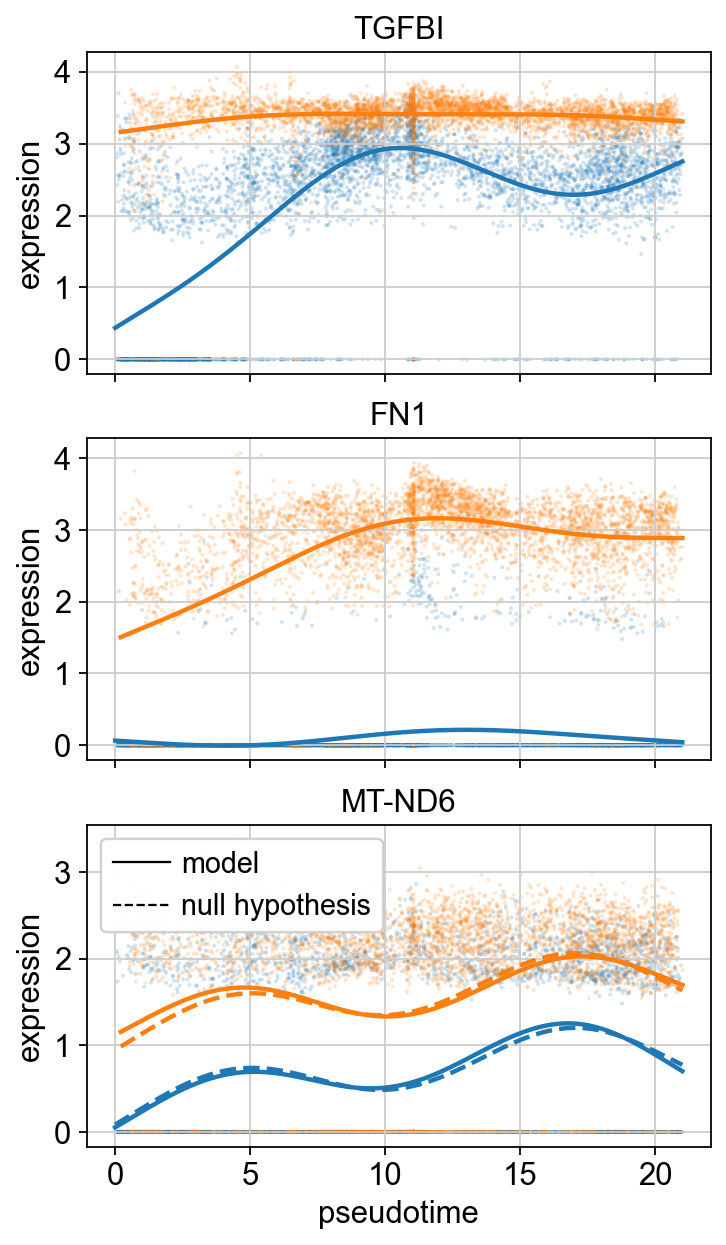

In [13]:
import matplotlib.pyplot as plt
sc.set_figure_params()
scf.set_figure_pubready()
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(5,9),sharex=True)
scf.pl.trend_covariate(adata,"TGFBI","treatment_id",alpha=.2,ax=ax1,show=False,legend_loc="none")
scf.pl.trend_covariate(adata,"FN1","treatment_id",alpha=.2,ax=ax2,show=False,legend_loc="none")
scf.pl.trend_covariate(adata,"MT-ND6","treatment_id",alpha=.2,show_null=True,ax=ax3,show=False,legend_loc="none")
ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("pseudotime")
plt.savefig("figures/covariate_2.pdf",dpi=300)